# Sentinel Hub OGC web services from within Python

## Web Map Service (WMS) and Web Coverage Service (WCS)

In this example notebook we show how to use WMS and WCS services provided by [Sentinel Hub](https://www.sentinel-hub.com/develop/documentation/api/ogc_api) to download satellite imagery. We describe how to use various parameters and configurations to obtain either processed products or raw band data.

We start with examples using Sentinel-2 L1C data and then show how to also obtain Sentinel-2 L2A, Sentinel-1, Landsat 8, MODIS and DEM data.

### Prerequisites

#### Sentinel Hub account

In order to use Sentinel Hub services you will need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).

Once you have the account set up, login to [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/). Inside there will already exist one configuration with an **instance ID** (alpha-numeric code of length 36). For this tutorial it is recommended that you create a new configuration (`"Add new configuration"`) and set the configuration to be based on **Python scripts template**. Such configuration will already contain all layers used in these examples. Otherwise you will have to define the layers for your  configuration yourself.

After you have decided which configuration to use, you have two options. You can either put configuration's **instance ID** into `sentinelhub` package's configuration file following the [configuration instructions](http://sentinelhub-py.readthedocs.io/en/latest/configure.html) or you can write it down in the following cell:

In [1]:
from sentinelhub import SHConfig


INSTANCE_ID = ''  # In case you put instance ID into configuration file you can leave this unchanged

if INSTANCE_ID:
    config = SHConfig()
    config.instance_id = INSTANCE_ID
else:
    config = None

#### Imports 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime
import numpy as np

import matplotlib.pyplot as plt

Note: `matplotlib` is not a dependency of `sentinelhub`.

In [4]:
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox

In [5]:
def plot_image(image, factor=1):
    """
    Utility function for plotting RGB images.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
    
    if np.issubdtype(image.dtype, np.floating):
        plt.imshow(np.minimum(image * factor, 1))
    else:
        plt.imshow(image)

#### Setting area of interest

We will download Sentinel-2 imagery of [Betsiboka Estuary](https://en.wikipedia.org/wiki/Betsiboka_River) such as the one shown below (taken by Sentinel-2 on 2017-12-15):
![title](data/wms_TRUE_COLOR_EPSG4326_-16.15_46.16_-15.58_46.51_2017-12-15T07-12-03_512X856.png)

The bounding box in _WGS84_ coordinate system is (longitude and latitude coordinates of upper left and lower right corners):

In [6]:
betsiboka_coords_wgs84 = [46.16, -16.15, 46.51, -15.58]

All requests require bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.geometry.CRS`). In our case it is in _WGS84_ and we can use the predefined _WGS84_ coordinate reference system from `sentinelhub.geometry.CRS`.

In [7]:
betsiboka_bbox = BBox(bbox=betsiboka_coords_wgs84, crs=CRS.WGS84)

### WMS request 

#### Example 1: True color (PNG) on a specific date

We need to specify the following arguments in the initialization of a `WmsRequest`:

 * `layer` - set it to `'TRUE-COLOR-S2-L1C'`
    * In case you are not using a configuration based on **Python scripts template** you will now have to create a layer named `TRUE-COLOR-S2-L1C` yourself. In [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/) go to your configuration, add new layer which will use Sentinel-2 L1C data source and predefined product `TRUE COLOR, RGB Visualization` for `Data processing` parameter.
 * `bbox` - see above
 * `time` - acquisition date 
     * we'll set it to 2017-12-15
 * `width` and `height` - width and height of a returned image
     * we'll set them to 512 and 856, respectively
     * we could only set one of the two parameters and the other one would be set automatically in a way that image would best fit bounding box ratio 
 * `instance_id` - see above
 
All of the above arguments are obligatory and have to be set for all `WmsRequest`.

In [8]:
wms_true_color_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox, 
    time='2017-12-15', 
    width=512,
    height=856,
    config=config
)

In [9]:
wms_true_color_img = wms_true_color_request.get_data()

Method `get_data()` will always return a list images in form of numpy arrays.

In [10]:
print('Returned data is of type = %s and length %d.' % (type(wms_true_color_img), len(wms_true_color_img)))

Returned data is of type = <class 'list'> and length 1.


In [11]:
print('Single element in the list is of type {} and has shape {}'.format(type(wms_true_color_img[-1]),
                                                                         wms_true_color_img[-1].shape))

Single element in the list is of type <class 'numpy.ndarray'> and has shape (856, 512, 3)


In [12]:
plot_image(wms_true_color_img[-1])

#### Example 2: True color of the latest acquisition

In order to get the latest Sentinel-2 acquisition set the `time` argument to `'latest'`.

In [13]:
wms_true_color_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox,
    time='latest',
    width=512,
    height=856,
    config=config
)

In [14]:
wms_true_color_img = wms_true_color_request.get_data()

In [15]:
plot_image(wms_true_color_img[-1])

In [16]:
print('The latest Sentinel-2 image of this area was taken on {}.'.format(wms_true_color_request.get_dates()[-1]))

The latest Sentinel-2 image of this area was taken on 2020-02-13 07:14:02.


In case a part of the image above is completely white that is because the latest acquisition only partially intersected the specified bounding box. To avoid that we could use a `time_difference` parameter described in [Example 8](#Example-8:-Merging-two-or-more-download-requests-into-one).

#### Example 3: True color of the multiple acquisitions in certain time window

In order to get all Sentinel-2 acquisitions taken in a certain time interval set the `time` argument to tuple with two elements (`start date`,`end date`).

In [17]:
wms_true_color_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox,
    time=('2017-12-01', '2017-12-31'),
    width=512,
    height=856,
    config=config
)

In [18]:
wms_true_color_img = wms_true_color_request.get_data()

In [19]:
print('There are %d Sentinel-2 images available for December 2017.' % len(wms_true_color_img))

There are 6 Sentinel-2 images available for December 2017.


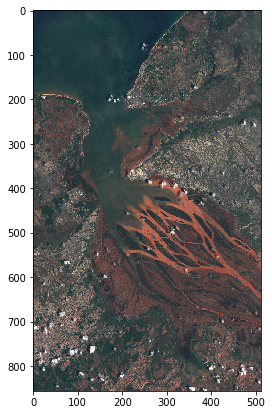

In [20]:
plot_image(wms_true_color_img[2])

In [21]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 6 images were taken on the following dates:
 - image 0 was taken on 2017-12-05 07:13:30
 - image 1 was taken on 2017-12-10 07:12:10
 - image 2 was taken on 2017-12-15 07:12:03
 - image 3 was taken on 2017-12-20 07:12:10
 - image 4 was taken on 2017-12-25 07:12:04
 - image 5 was taken on 2017-12-30 07:12:09


#### Example 4: True color of the multiple acquisitions in certain time window with cloud coverage less than 30%

In order to get only Sentinel-2 acquisitions with cloud coverage less than certain amount set `maxcc` argument to that value. Note that this cloud coverage is estimated on the entire Sentinel-2 tile and not just for the region defined by our bounding box.

In [22]:
wms_true_color_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox,
    time=('2017-12-01', '2017-12-31'),
    width=512, height=856, 
    maxcc=0.3,
    config=config
)

In [23]:
wms_true_color_img = wms_true_color_request.get_data()

In [24]:
print('There are %d Sentinel-2 images available for December 2017 with cloud coverage less ' \
      'than %1.0f%%.' % (len(wms_true_color_img), wms_true_color_request.maxcc * 100.0))

There are 2 Sentinel-2 images available for December 2017 with cloud coverage less than 30%.


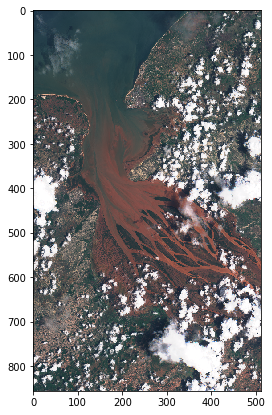

In [25]:
plot_image(wms_true_color_img[-1])

In [26]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 2 images were taken on the following dates:
 - image 0 was taken on 2017-12-15 07:12:03
 - image 1 was taken on 2017-12-20 07:12:10


#### Example 5: All Sentinel-2's raw band values 

Now let's use a layer named `BANDS-S2-L1C` which will return all Sentinel-2 spectral bands with raw values.

If you are not using a configuration based on **Python scripts template** you will again have to create such layer manually. In that case define `Data processing` parameter with the following custom script:
```Javascript
return [B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,B10,B11,B12]
```

We have to set the `image_format` argument to `sentinelhub.constants.MimeType.TIFF_d32f`, since we can't pack all Sentinel-2's 13 bands into a png image. This format will also ensure that we will get image reflectance in 32-bit float values.

In [27]:
wms_bands_request = WmsRequest(
    layer='BANDS-S2-L1C',
    bbox=betsiboka_bbox, 
    time='2017-12-15',
    width=512,
    height=856,
    image_format=MimeType.TIFF_d32f,
    config=config
)

wms_bands_img = wms_bands_request.get_data()

In [28]:
wms_bands_img[-1][:, :, 12].shape

(856, 512)

Image showing SWIR band B12

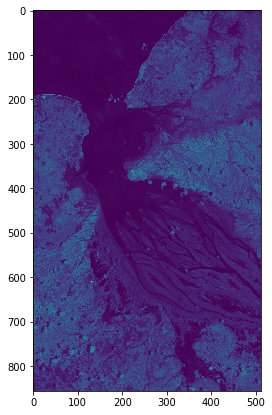

In [29]:
plot_image(wms_bands_img[-1][:, :, 12])

From raw bands we can also construct a true color image

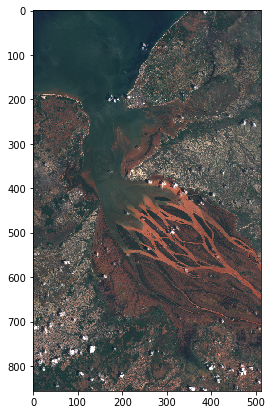

In [30]:
plot_image(wms_bands_img[-1][:, :, [3, 2, 1]], 2.5)

#### Example 6: Save downloaded data to disk and read it from disk

All downloaded data can be saved to disk and later read from it. Simply specify the location on disk where data should be saved (or loaded from) via `data_folder` argument of request's constructor and set the argument `save_data` of `get_data` method to `True`.

In [31]:
wms_bands_request = WmsRequest(
    data_folder='test_dir',
    layer='BANDS-S2-L1C',
    bbox=betsiboka_bbox, 
    time='2017-12-15', 
    width=512,
    height=856,
    image_format=MimeType.TIFF_d32f,
    config=config
)

In [32]:
%%time
wms_bands_img = wms_bands_request.get_data(save_data=True)

CPU times: user 152 ms, sys: 12 ms, total: 164 ms
Wall time: 173 ms


The output directory has been created and a tiff file with all 13 bands was saved into the following structure:

In [33]:
import os

for folder, _, filenames in os.walk(wms_bands_request.data_folder):
    for filename in filenames:
        print(os.path.join(folder, filename))

test_dir/0fff212855a989d93b425cbd8ce7a55f/request.json
test_dir/0fff212855a989d93b425cbd8ce7a55f/response.tiff


Since data has been already downloaded the next request will read the data from disk instead of downloading it. That will be much faster.

In [34]:
wms_bands_request_from_disk = WmsRequest(
    data_folder='test_dir',
    layer='BANDS-S2-L1C',
    bbox=betsiboka_bbox,
    time='2017-12-15',
    width=512,
    height=856,
    image_format=MimeType.TIFF_d32f,
    config=config
)

In [35]:
%%time

wms_bands_img_from_disk = wms_bands_request_from_disk.get_data()

CPU times: user 168 ms, sys: 8 ms, total: 176 ms
Wall time: 178 ms


In [36]:
if np.array_equal(wms_bands_img[-1], wms_bands_img_from_disk[-1]):
    print('Arrays are equal.')
else:
    print('Arrays are different.')

Arrays are equal.


If you need to redownload the data again, just set the `redownload` argument of `get_data()` method to `True`. 

In [37]:
%%time
wms_bands_img_redownload = wms_bands_request_from_disk.get_data(redownload=True)

CPU times: user 280 ms, sys: 16 ms, total: 296 ms
Wall time: 11.8 s


#### Example 7: Save downloaded data directly to disk

The `get_data` method returns a list of numpy arrays and can save the downloaded data to disk, as we have seen in the previous example. Sometimes you would just like to save the data directly to disk for later use. You can do that by using `save_data` method instead.

This time instead of png images let's download 16-bit tiff images.

In [38]:
wms_true_color_request = WmsRequest(
    data_folder='test_dir_tiff',
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox,
    time=('2017-12-01','2017-12-31'),
    width=512,
    height=856,
    image_format=MimeType.TIFF,
    config=config
)

In [39]:
%%time
wms_true_color_request.save_data()

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 8.77 ms


The output directory has been created and tiff files for all 6 images should be in it.

In [40]:
os.listdir(wms_true_color_request.data_folder)

['8ba386f323a21e89113aeab2e81302f9',
 'a685f3f48ce194f7223c26bc9625c8bb',
 '8d8abf996631a125bafa53317923afb5',
 '98a9b5f3340dcfeb689f03b3299ebb0c',
 '0e93b1569f01b03cb1f979dda3a0da0c',
 'b84057ed6be6b75bad51d4442aad5d07']

#### Example 8: Merging two or more download requests into one

If the bounding box spans over two or more Sentinel-2 tiles and each of them has slightly different time stamp, then download request will be created for each time stamp. Therefore we will obtain two or more images which could be completely the same or partially blank. It depends on whether the tiles from the same orbit are from the same or from two different data strips.

Let's look at the specific example. Again, we're going to look at Betsiboka estuary, but we'll increase the bounding box so that we cover an area of two different Senteinel-2 tiles.

In [41]:
betsiboka_bbox_large = BBox([45.88, -16.12, 47.29, -15.45], crs=CRS.WGS84)

wms_true_color_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox_large,
    time='2015-12-01',
    width=960,
    image_format=MimeType.PNG,
    config=config
)

wms_true_color_img = wms_true_color_request.get_data()

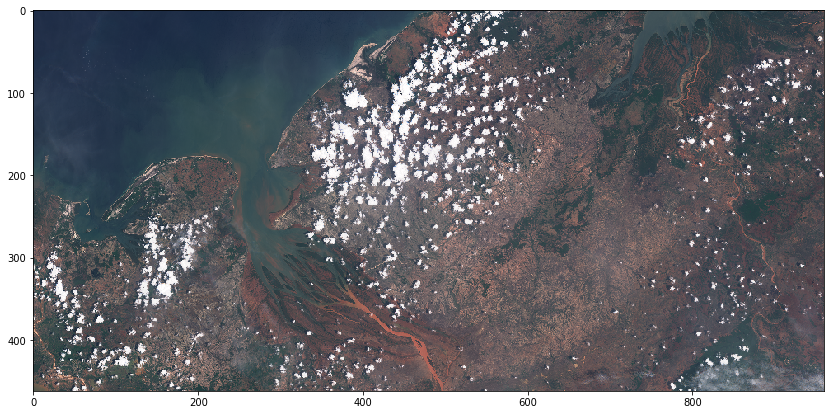

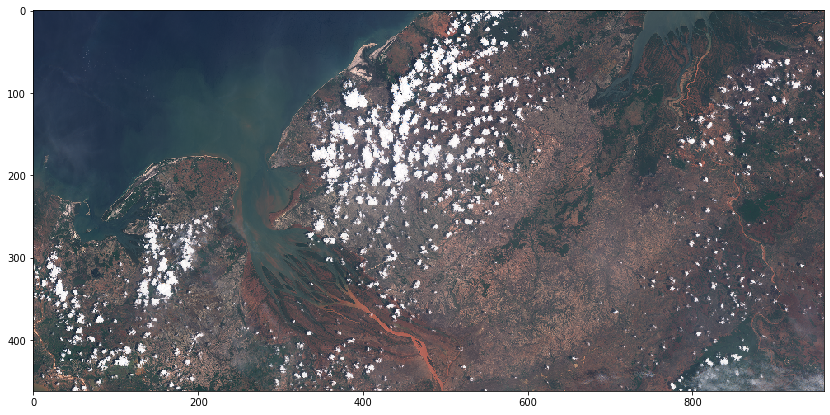

In [42]:
plot_image(wms_true_color_img[0])
plot_image(wms_true_color_img[1])

Clearly these are the same images and we usually would want to get only one. We can do that by widening the time interval in which two or more download requests are considered to be the same. In our example it is enough to widen the time window for 10 minutes, but usually it can be up to two hours. This is done by setting the `time_difference` argument.

In [43]:
wms_true_color_request_with_deltat = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox_large,
    time='2015-12-01',
    width=960,
    image_format=MimeType.PNG,
    time_difference=datetime.timedelta(hours=2),
    config=config
)

wms_true_color_img = wms_true_color_request_with_deltat.get_data()

In [44]:
print('These %d images were taken on the following dates:' % len(wms_true_color_img))
for index, date in enumerate(wms_true_color_request_with_deltat.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 1 images were taken on the following dates:
 - image 0 was taken on 2015-12-01 07:12:50


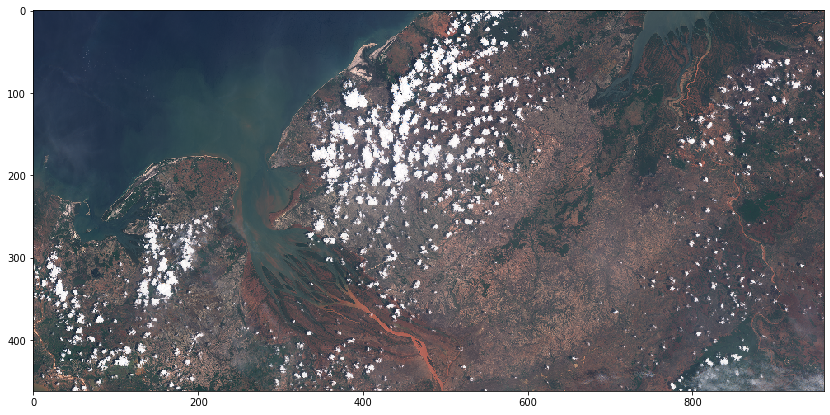

In [45]:
plot_image(wms_true_color_img[-1])

### WCS request

The use of `WcsRequest` is exactly the same as of the `WmsRequest` shown above. The only difference is that instead of specifying image size we specify the spatial resolution of the image. We do that by setting the `resx` and `resy` arguments to the desired resolution in meters. E.g. setting `resx='10m'` and `resy='10m'` will return an image where every pixel will cover an area of size `10m x 10m`.

Every other parameter described in this tutorial will work the same for WMS and WCS requests.

#### Example 9: True color with specified resolution 

In [46]:
wcs_true_color_request = WcsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox,
    time='2017-12-15',
    resx='60m',
    resy='60m',
    config=config
)

wcs_true_color_img = wcs_true_color_request.get_data()

In [47]:
print('Single element in the list is of type = {} and has shape {}'.format(type(wcs_true_color_img[-1]),
                                                                           wcs_true_color_img[-1].shape))

Single element in the list is of type = <class 'numpy.ndarray'> and has shape (1057, 624, 3)


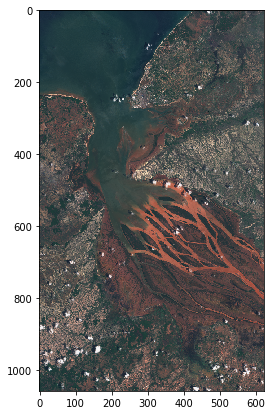

In [48]:
plot_image(wcs_true_color_img[-1])

### Custom URL Parameters

Sentinel Hub OGC services have various custom URL parameters described at the [webpage](https://www.sentinel-hub.com/develop/documentation/api/custom-url-parameters). Many of them are supported in this package and some of them might be added in the future. Let's check which ones currently exist.

In [49]:
from sentinelhub import CustomUrlParam

list(CustomUrlParam)

[<CustomUrlParam.SHOWLOGO: 'ShowLogo'>,
 <CustomUrlParam.ATMFILTER: 'AtmFilter'>,
 <CustomUrlParam.EVALSCRIPT: 'EvalScript'>,
 <CustomUrlParam.EVALSCRIPTURL: 'EvalScriptUrl'>,
 <CustomUrlParam.PREVIEW: 'Preview'>,
 <CustomUrlParam.QUALITY: 'Quality'>,
 <CustomUrlParam.UPSAMPLING: 'Upsampling'>,
 <CustomUrlParam.DOWNSAMPLING: 'Downsampling'>,
 <CustomUrlParam.TRANSPARENT: 'Transparent'>,
 <CustomUrlParam.BGCOLOR: 'BgColor'>,
 <CustomUrlParam.GEOMETRY: 'Geometry'>]

Many of these parameters already appear in [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/) as a property of an instance or a layer. However any parameter we specify in the code will automatically override the definition in Configurator for our request.

#### Example 10: Using Custom URL Parameters

We can request true color image with atmospheric correction, transparency layer and and no logo.

In [50]:
custom_wms_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C',
    bbox=betsiboka_bbox,
    time='2019-11-05',
    width=512,
    height=856,
    custom_url_params={
        CustomUrlParam.ATMFILTER: 'ATMCOR',
        CustomUrlParam.TRANSPARENT: True,
        CustomUrlParam.SHOWLOGO: False
    },
    config=config
)

custom_wms_data = custom_wms_request.get_data()

Obtained true color images have a transparency channel indicating which parts of the image have no data.

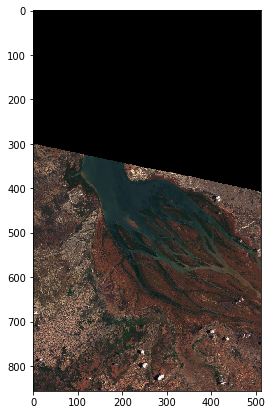

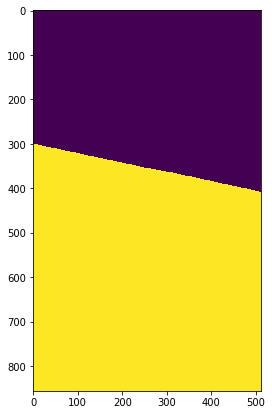

In [51]:
plot_image(custom_wms_data[-1][:, :, :3])
plot_image(custom_wms_data[-1][:, :, 3])

#### Example 11: Evalscript

Instead of using Sentinel Hub Configurator we can define our own custom layers inside Python with ``CustomUrlParam.EVALSCRIPT``. All we need is a chunk of code written in Javascript which is not too long to fit into an URL.

Let's implement a simple cloud detection algorithm.

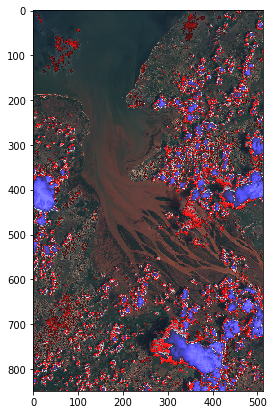

In [52]:
# by Braaten, Cohen, Yang 2015
my_evalscript = '''
var bRatio = (B01 - 0.175) / (0.39 - 0.175);
var NGDR = (B01 - B02) / (B01 + B02);

function clip(a) {
    return a>0 ? (a<1 ? a : 1) : 0;
}
    
if (bRatio > 1) {
    var v = 0.5*(bRatio - 1);
    return [0.5*clip(B04), 0.5*clip(B03), 0.5*clip(B02) + v];
}
    
if (bRatio > 0 && NGDR > 0) {
    var v = 5 * Math.sqrt(bRatio * NGDR);
    return [0.5 * clip(B04) + v, 0.5 * clip(B03), 0.5 * clip(B02)];
}
    
return [2*B04, 2*B03, 2*B02];
'''

evalscript_wms_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C', # Layer parameter can be any existing layer
    bbox=betsiboka_bbox,
    time='2017-12-20',
    width=512,
    custom_url_params={CustomUrlParam.EVALSCRIPT: my_evalscript},
    config=config
)

evalscript_wms_data = evalscript_wms_request.get_data()
plot_image(evalscript_wms_data[0])

Note: We still had to specify an existing layer from Configurator. That is because each layer is linked with it's data source and we cannot override layer's data source from the code. 

#### Example 12: Evalscript URL

Another option is to simply provide an URL address of an evalscript written in Javascript. For that purpose we have created a [collection of useful custom scripts on Github](https://github.com/sentinel-hub/custom-scripts).

Let's select a script for calculating moisture index and provide its URL as a value of parameter `CustomUrlParam.EVALSCRIPTURL`.

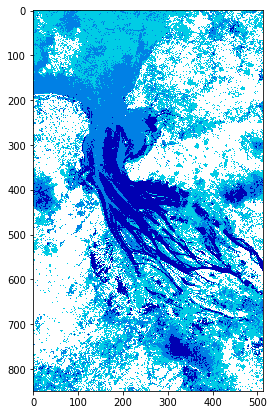

In [53]:
my_url = 'https://raw.githubusercontent.com/sentinel-hub/custom-scripts/master/sentinel-2/ndmi_special/script.js'

evalscripturl_wms_request = WmsRequest(
    layer='TRUE-COLOR-S2-L1C', # Layer parameter can be any existing layer
    bbox=betsiboka_bbox,
    time='2017-12-20',
    width=512,
    custom_url_params={CustomUrlParam.EVALSCRIPTURL: my_url},
    config=config
)

evalscripturl_wms_data = evalscripturl_wms_request.get_data()
plot_image(evalscripturl_wms_data[0])

### Data Sources

The package supports various data sources. Default data source is Sentinel-2 L1C however currently the following is supported:

In [54]:
from sentinelhub import DataSource

for source in DataSource.get_available_sources():
    print(source)

DataSource.SENTINEL2_L1C
DataSource.SENTINEL2_L2A
DataSource.SENTINEL1_IW
DataSource.SENTINEL1_EW
DataSource.SENTINEL1_EW_SH
DataSource.SENTINEL1_IW_ASC
DataSource.SENTINEL1_EW_ASC
DataSource.SENTINEL1_EW_SH_ASC
DataSource.SENTINEL1_IW_DES
DataSource.SENTINEL1_EW_DES
DataSource.SENTINEL1_EW_SH_DES
DataSource.DEM
DataSource.MODIS
DataSource.LANDSAT8


In order to obtain data from any of these data sources with `WmsRequest` or `WcsRequest` we have to do the following: 

- Use  a configuration based on **Python scripts template** or create a new layer in [Sentinel Hub Configurator](https://apps.sentinel-hub.com/configurator/) that is defined to use desired satellite data source. Set the `layer` parameter of `WmsRequest` or `WcsRequest` to the name of this newly created layer.
- Set `data_source` parameter of `WmsRequest` or `WcsRequest` to the same data source (using one of the objects from the list above).

#### Example 13: Sentinel-2 L2A

When you have a layer named `TRUE-COLOR-S2-L2A` in your configuration let's try to obtain some level 2A images. Unfortunately L2A images are being processed only for some regions around the globe and Betsiboka Estuary is not one of them.

Instead let's check [Eyjafjallajökull volcano](https://en.wikipedia.org/wiki/Eyjafjallaj%C3%B6kull) on Iceland. This time we will provide coordinates in Popular Web Mercator CRS.

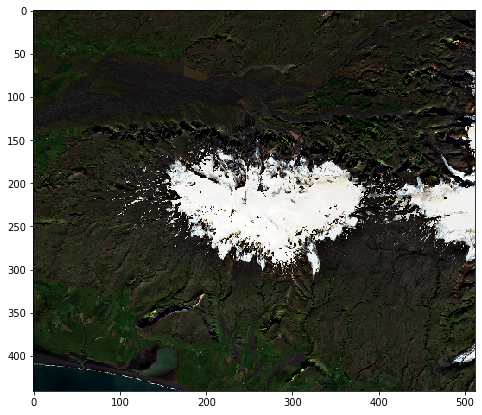

In [55]:
volcano_bbox = BBox(bbox=[(-2217485.0, 9228907.0), (-2150692.0, 9284045.0)], crs=CRS.POP_WEB)

l2a_request = WmsRequest(
    data_source=DataSource.SENTINEL2_L2A,
    layer='TRUE-COLOR-S2-L2A',
    bbox=volcano_bbox,
    time='2017-08-30',
    width=512,
    config=config
)

l2a_data = l2a_request.get_data()
plot_image(l2a_data[0])

#### Example 14: DEM

To check the elevation model of chosen area we need a layer `DEM` defined with the following custom script:

```Javascript
return [DEM]
```

Request using Mapzen DEM as a data source does not require a time parameter.

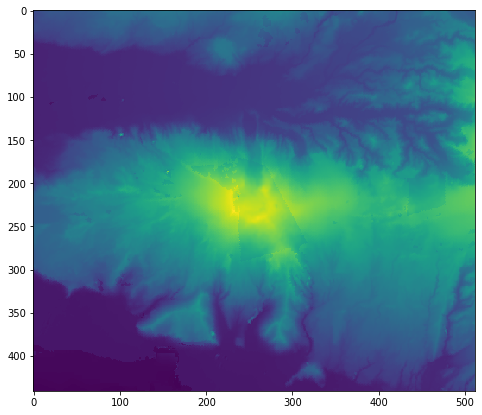

In [56]:
dem_request = WmsRequest(
    data_source=DataSource.DEM,
    layer='DEM',
    bbox=volcano_bbox,
    width=512,
    image_format=MimeType.TIFF_d32f,
    custom_url_params={CustomUrlParam.SHOWLOGO: False},
    config=config
)

dem_image = dem_request.get_data()[0]

plot_image(dem_image, 1 / np.amax(dem_image))

#### Example 15: Landsat 8

To view Landsat 8 L1C image we require a layer `TRUE-COLOR-L8` with predefined true color RGB template.

In [57]:
l8_request = WmsRequest(
    data_source=DataSource.LANDSAT8,
    layer='TRUE-COLOR-L8',
    bbox=volcano_bbox,
    time='2017-08-20',
    width=512,
    config=config
)

l8_data = l8_request.get_data()
plot_image(l8_data[-1])

#### Example 15: Sentinel-1

If we would like to avoid clouds using Sentinel-1 radar data seems like a good idea. The package supports obtaining multiple types of Sentinel-1 data. In this example we will use `DataSource.SENTINEL1_IW`. While creating layer in Sentinel Hub Configurator we must be careful to use the same settings as the supported data source: 

In [58]:
DataSource.SENTINEL1_IW

<DataSource.SENTINEL1_IW: (<_Source.SENTINEL1: 'Sentinel-1'>, <_ProcessingLevel.GRD: 'GRD'>, <_Acquisition.IW: 'IW'>, <_Polarisation.DV: 'VV+VH'>, <_Resolution.HIGH: 'high'>, <_OrbitDirection.BOTH: 'both'>)>

This tells us we have to set acquisition parameter to `IW`, polarisation to `DV`, resolution to `High` and orbit direction to `Both`. After that let's name the layer `TRUE-COLOR-S1-IW` and use the following custom script

```Javascript
return [VV, 2 * VH, VV / VH / 100.0]
```

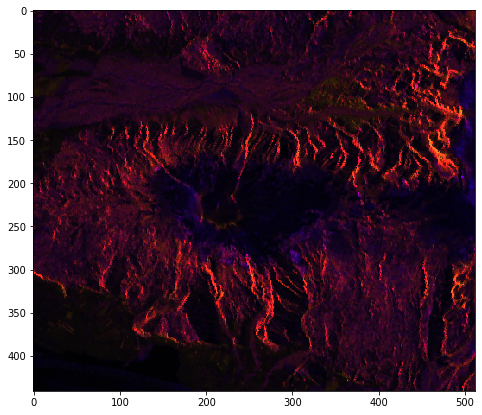

In [59]:
s1_request = WmsRequest(
    data_source=DataSource.SENTINEL1_IW,
    layer='TRUE-COLOR-S1-IW',
    bbox=volcano_bbox,
    time='2017-10-03',
    width=512,
    config=config
)

s1_data = s1_request.get_data()
plot_image(s1_data[-1])

#### Example 16: Sentinel-1, ascending orbit direction

Sentinel-1 data is acquired when a satellite travels either from approx. north to south (i.e. `DESCENDING` orbit direction) or from approx. south to north (i.e.`ASCENDING` orbit direction). With sentinelhub-py package one can request only the data with `ASCENDING` orbit direction if using a datasource ending with "\_ASC" (or only data with `DESCENDING` orbit direction when using datasource ending with "\_DES").   

E.g., the request below will fetch only the data with `ASCENDING` orbit direction:

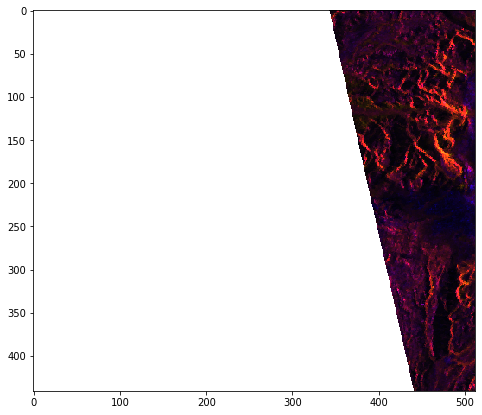

In [60]:
s1_asc_request = WmsRequest(
    data_source=DataSource.SENTINEL1_IW_ASC,
    layer='TRUE-COLOR-S1-IW',
    bbox=volcano_bbox,
    time=('2017-10-03','2017-10-05'),
    width=512,
    config=config
)

s1_asc_data = s1_asc_request.get_data()
plot_image(s1_asc_data[-1])

#### Example 17: Custom (BYOC) data

It is possible that you "bring your own data" (BYOC) and access it using Sentinel Hub in a similar manner as any other satellite data. 
To be able to access your own data using Sentinel Hub you will need to prepare a few things. Roughly speaking these are (find all details here: https://docs.sentinel-hub.com/api/latest/#/API/byoc):
- Convert your data to Cloud Optimized GeoTiff (COG) format. Store it in AWS S3 bucket and allow SH to access it.
- Create collection in SH, which points to the S3 bucket. Within the collection, create tiles. 
- Create new layer in your configuration, which points to the collection.
- Request the data using SentinelHub.py package

To demonstrate this, we have prepeared a demo S3 bucket, demo collection and demo layer in our configuration. To access this data we need collection id = '31df1de4-8bd4-43e0-8c3f-b04262d111b6' and layer id = 'DEMO_BYOC_LAYER'. Let see how to request the custom data.

In [ ]:
byoc_bbox = BBox([13.82387,45.85221, 13.83313, 45.85901], crs=CRS.WGS84)

collection_id = '<your collection id>'
layer = 'DEMO_BYOC_LAYER'

byoc_request = WmsRequest(
    data_source=DataSource(collection_id),
    layer=layer,
    bbox=byoc_bbox,
    width=512,
    config=config
)

byoc_data = byoc_request.get_data()
plot_image(byoc_data[-1])